Starting TINN training...
Epoch 00000: Loss = 2.13509575e-01
Epoch 00050: Loss = 4.81785927e-03
Epoch 00100: Loss = 6.89774111e-04
Epoch 00150: Loss = 2.38589972e-04
Epoch 00200: Loss = 1.17975062e-04
Epoch 00250: Loss = 1.24197177e-04
Epoch 00300: Loss = 8.00081398e-05
Epoch 00350: Loss = 1.22284633e-04
Epoch 00400: Loss = 6.10460775e-05
Epoch 00450: Loss = 4.31178851e-05
Epoch 00500: Loss = 3.39719372e-05
Epoch 00550: Loss = 5.20933245e-05
Epoch 00600: Loss = 2.55558498e-05
Epoch 00650: Loss = 7.00309902e-05
Epoch 00700: Loss = 3.27320959e-05
Epoch 00750: Loss = 1.69706036e-05
Epoch 00800: Loss = 1.47927803e-05
Epoch 00850: Loss = 5.43302740e-04
Epoch 00900: Loss = 1.88171671e-05
Epoch 00950: Loss = 1.63228506e-05
Epoch 01000: Loss = 1.04554938e-05
Epoch 01050: Loss = 1.03145676e-05
Epoch 01100: Loss = 1.01971191e-05
Epoch 01150: Loss = 1.00787747e-05
Epoch 01200: Loss = 9.95966911e-06
Epoch 01250: Loss = 9.84001599e-06
Epoch 01300: Loss = 9.71982081e-06
Epoch 01350: Loss = 9.5993336

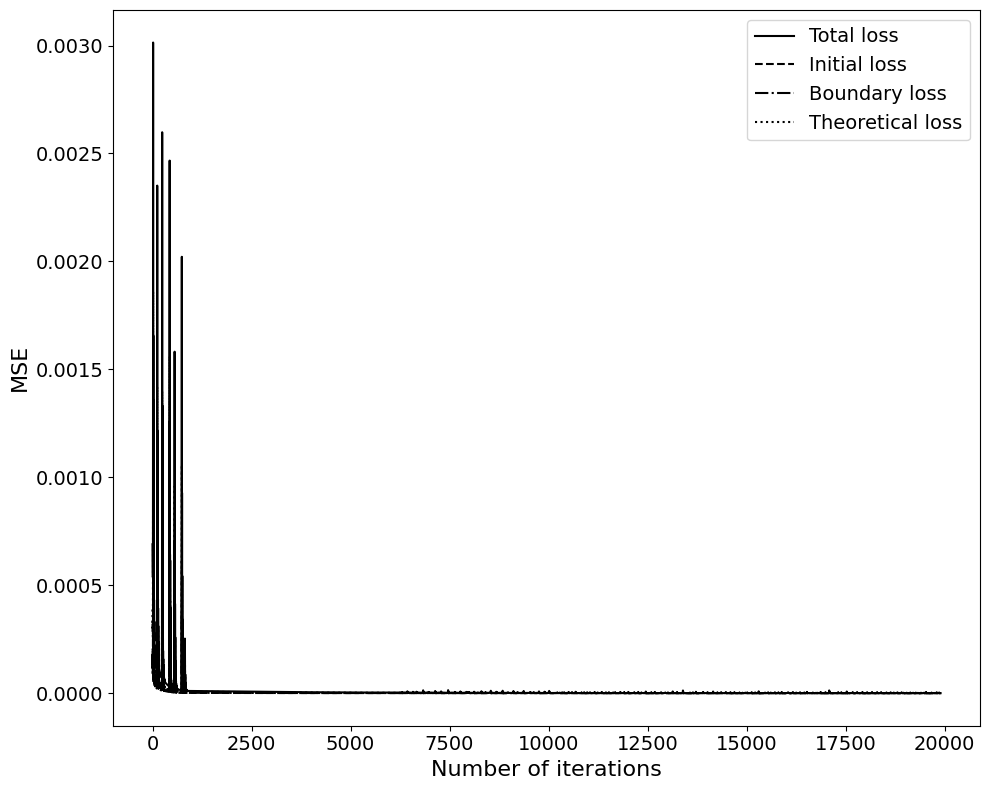

Running finite difference solver...
Computing first passage times...


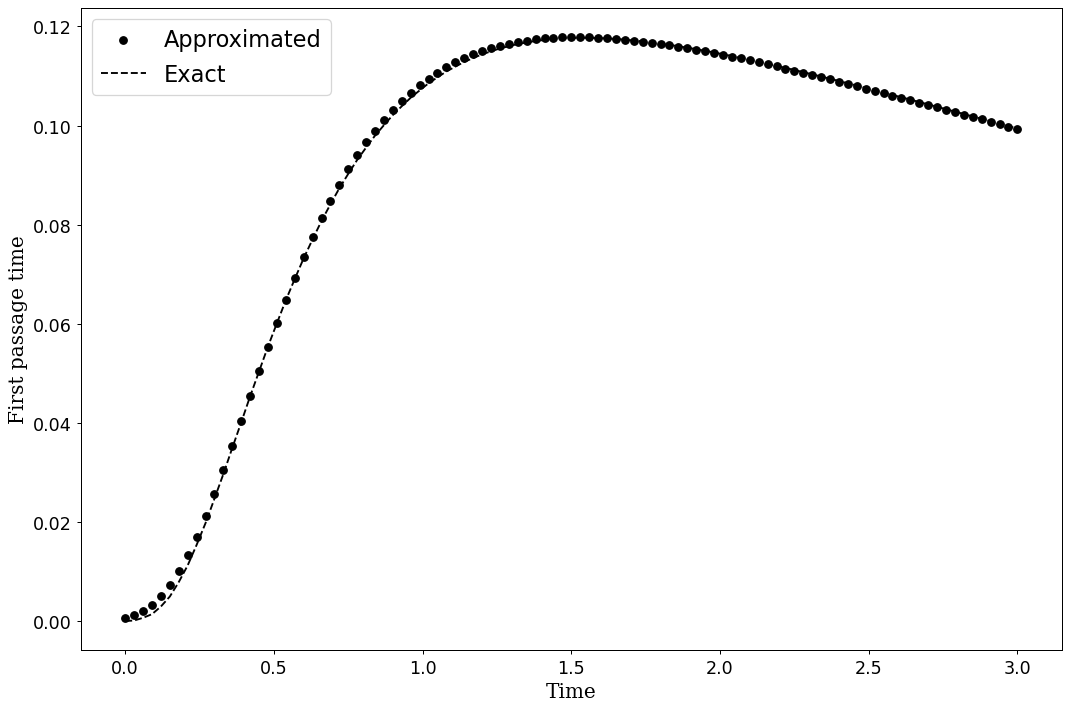

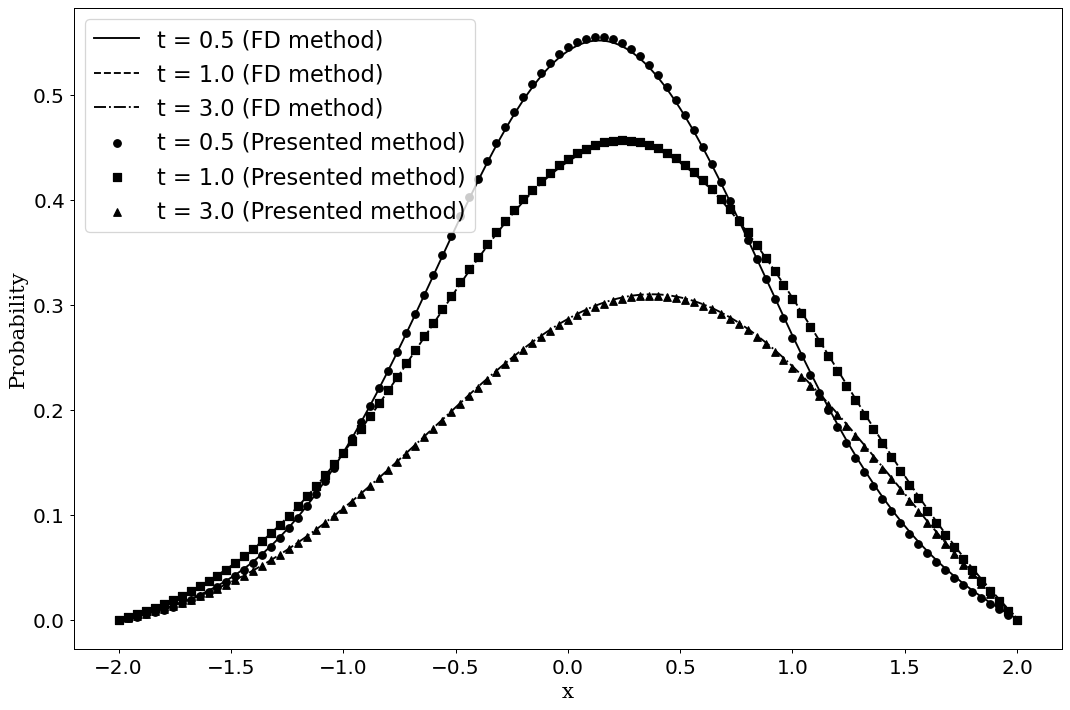

Analysis completed successfully!


In [4]:
"""
Theoretical-Informed Neural Network (TINN) for Solving Fokker-Planck Equation
with State-Dependent Drift and First Passage Time Analysis
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize


# =============================================================================
# Configuration and Constants
# =============================================================================

# Physical parameters
BETA_J = 0.4
DELTA = 7.8e-2
SIGMA = 1.0

# State-dependent drift parameters
V0 = 0.3
BETA = BETA_J

# Domain boundaries
TMIN, TMAX = 0.0, 3.0
XMIN, XMAX = -2.0, 2.0

# Training parameters
N_0 = 100    # Initial condition points
N_B = 200    # Boundary condition points
N_R = 5000   # Residual collocation points
NUM_EPOCHS = 20000

# Neural network architecture
NUM_HIDDEN_LAYERS = 5
NUM_NEURONS_PER_LAYER = 30

# Set data type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)


# =============================================================================
# Physics Definitions
# =============================================================================

def dirac_delta_function(x, delta):
    """Approximate Dirac delta function as a Gaussian distribution."""
    return 1 / (2 * np.sqrt(np.pi * delta)) * tf.math.exp(-((x - 0.0)**2) / (4 * delta))


def state_dependent_drift(x):
    """Define state-dependent drift coefficient."""
    return V0 - BETA * x


def initial_condition(x):
    """Define initial condition at t=0."""
    return dirac_delta_function(x, DELTA)


def boundary_condition(t, x):
    """Define boundary condition."""
    n = x.shape[0]
    return tf.zeros((n, 1), dtype=DTYPE)


def pde_residual(t, x, u, u_t, u_x, u_xx):
    """Define the PDE residual (Fokker-Planck equation with state-dependent drift)."""
    return u_t + state_dependent_drift(x) * u_x - 0.5 * SIGMA**2 * u_xx - BETA * u


# =============================================================================
# Data Preparation
# =============================================================================

def prepare_training_data():
    """Prepare initial, boundary, and collocation points for training."""

    # Domain bounds
    lb = tf.constant([TMIN, XMIN], dtype=DTYPE)
    ub = tf.constant([TMAX, XMAX], dtype=DTYPE)

    # Initial condition data
    t_0 = tf.ones((N_0, 1), dtype=DTYPE) * lb[0]
    x_0 = np.linspace(lb[1], ub[1], N_0 - 1, dtype=DTYPE)
    x_0 = np.asarray(list(x_0) + [0.0])  # Ensure point at x=0 is included
    x_0 = tf.convert_to_tensor(x_0, dtype=DTYPE)
    x_0 = tf.reshape(x_0, [N_0, 1])
    u_0 = initial_condition(x_0)
    X_0 = tf.concat([t_0, x_0], axis=1)

    # Boundary condition data
    t_b = tf.random.uniform((N_B, 1), lb[0], ub[0], dtype=DTYPE)
    x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli(
        (N_B, 1), 0.5, dtype=DTYPE)
    X_b = tf.concat([t_b, x_b], axis=1)
    u_b = boundary_condition(t_b, x_b)

    # Collocation points for PDE residual
    t_r = tf.random.uniform((N_R, 1), lb[0], ub[0], dtype=DTYPE)
    x_r = tf.random.uniform((N_R, 1), lb[1], ub[1], dtype=DTYPE)
    X_r = tf.concat([t_r, x_r], axis=1)

    # Collect all data
    X_data = [X_0, X_b]
    u_data = [u_0, u_b]

    return X_r, X_data, u_data, lb, ub


# =============================================================================
# Neural Network Model
# =============================================================================

def create_model(num_hidden_layers=5, num_neurons_per_layer=30):
    """Create the TINN model architecture."""
    model = tf.keras.Sequential()

    # Input layer (time + space)
    model.add(tf.keras.Input(shape=(2,)))

    # Hidden layers
    for _ in range(num_hidden_layers - 1):
        model.add(tf.keras.layers.Dense(
            num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'
        ))

    # Final hidden layer with softmax activation
    model.add(tf.keras.layers.Dense(
        num_neurons_per_layer,
        activation='softmax'
    ))

    # Output layer
    model.add(tf.keras.layers.Dense(1))

    return model


def compute_pde_residual(model, X_r):
    """Compute the PDE residual using automatic differentiation."""
    with tf.GradientTape(persistent=True) as tape:
        # Split inputs
        t, x = X_r[:, 0:1], X_r[:, 1:2]

        # Watch variables for gradient computation
        tape.watch(t)
        tape.watch(x)

        # Compute solution
        u = model(tf.stack([t[:, 0], x[:, 0]], axis=1))

        # Compute first derivatives
        u_x = tape.gradient(u, x)

    # Compute higher derivatives
    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    del tape

    return pde_residual(t, x, u, u_t, u_x, u_xx)


# =============================================================================
# Training Utilities
# =============================================================================

def compute_loss(model, X_r, X_data, u_data):
    """Compute the total loss function."""
    # PDE residual loss
    r = compute_pde_residual(model, X_r)
    loss_pde = tf.reduce_mean(tf.square(r))

    # Initial condition loss
    u_pred_0 = model(X_data[0])
    loss_ic = tf.reduce_mean(tf.square(u_data[0] - u_pred_0))

    # Boundary condition loss
    u_pred_1 = model(X_data[1])
    loss_bc = tf.reduce_mean(tf.square(u_data[1] - u_pred_1))

    # Total loss
    total_loss = loss_pde + loss_ic + loss_bc

    return total_loss, loss_pde, loss_ic, loss_bc


def get_gradients(model, X_r, X_data, u_data):
    """Compute gradients of the loss function."""
    with tf.GradientTape(persistent=True) as tape:
        loss, loss_pde, loss_ic, loss_bc = compute_loss(
            model, X_r, X_data, u_data)

    gradients = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, gradients, loss_pde, loss_ic, loss_bc


def setup_optimizer():
    """Setup the optimizer with learning rate schedule."""
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        [1000, 5000, 20000],
        [1e-2, 1e-3, 5e-4, 1e-4]
    )
    return tf.keras.optimizers.Adam(learning_rate=lr_schedule)


@tf.function
def train_step(model, X_r, X_data, u_data, optimizer):
    """Single training step."""
    loss, gradients, loss_pde, loss_ic, loss_bc = get_gradients(
        model, X_r, X_data, u_data)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, loss_pde, loss_ic, loss_bc


def train_model(model, X_r, X_data, u_data):
    """Train the TINN model."""
    optimizer = setup_optimizer()

    # History tracking
    history = {
        'total_loss': [],
        'pde_loss': [],
        'ic_loss': [],
        'bc_loss': []
    }

    print("Starting TINN training...")
    t0 = time()

    for epoch in range(NUM_EPOCHS + 1):
        loss, loss_pde, loss_ic, loss_bc = train_step(
            model, X_r, X_data, u_data, optimizer)

        # Store history
        history['total_loss'].append(loss.numpy())
        history['pde_loss'].append(loss_pde.numpy())
        history['ic_loss'].append(loss_ic.numpy())
        history['bc_loss'].append(loss_bc.numpy())

        # Print progress
        if epoch % 50 == 0:
            print(f'Epoch {epoch:05d}: Loss = {loss.numpy():10.8e}')

    training_time = time() - t0
    print(f'\nTraining completed in {training_time:.2f} seconds')

    return history


# =============================================================================
# Finite Difference Solver
# =============================================================================

def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    """Create tridiagonal matrix."""
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)


def state_dependent_drift_fd(x):
    """State-dependent drift for finite difference solver."""
    return V0 - BETA * x


def finite_difference_solver():
    """Solve the PDE using finite difference method for validation."""
    # Parameters
    L = 4         # Length of the domain
    N = 500       # Number of spatial points
    T = 3         # Total time
    dt = 0.03     # Time step

    # Spatial grid
    x = np.linspace(-2, 2, N)
    dx = x[1] - x[0]

    # Initial condition: Gaussian distribution
    P = 1/(2*np.sqrt(np.pi*DELTA))*np.exp(-((x-0.)**2)/(4*DELTA))

    # Time evolution
    timesteps = int(T / dt)
    P_all = np.zeros((N, timesteps+1))
    P_all[:, 0] = P

    # Precompute drift values
    dd = state_dependent_drift_fd(x)

    for t in range(timesteps):
        P_new = np.zeros_like(P)
        tt = t * dt

        # Construct matrices for finite difference scheme
        a = (-dt/(4*dx**2))*np.ones((N-1)) - (dt)/(4*dx) * dd[1:]
        b = (1 + (dt/(2*dx**2)) - BETA*dt/2) * np.ones((N))
        c = (-dt/(4*dx**2))*np.ones((N-1)) + (dt)/(4*dx) * dd[:-1]
        A = tridiag(a, b, c)

        aa = (dt/(4*dx**2))*np.ones((N-1)) + (dt)/(4*dx) * dd[1:]
        bb = (1 - (dt/(2*dx**2)) + BETA*dt/2) * np.ones((N))
        cc = (dt/(4*dx**2))*np.ones((N-1)) - (dt)/(4*dx) * dd[:-1]
        B = tridiag(aa, bb, cc)

        # Solve system
        P_new = np.linalg.inv(A) @ B @ P

        # Boundary conditions (Dirichlet)
        P_new[0] = 0
        P_new[-1] = 0

        P = P_new
        P_all[:, t+1] = P

    return P_all, x


# =============================================================================
# First Passage Time Analysis
# =============================================================================

def compute_first_passage_time(model, lb, ub, P_all, N=100):
    """Compute first passage time using both TINN and finite difference solutions."""
    tspace = np.linspace(0, ub[0], N + 1)

    # TINN solution for first passage time
    xspace = np.ones((N+1)) * ub[1]
    X = np.zeros((N+1, 2))
    X[:, 0] = tspace
    X[:, 1] = xspace
    X = tf.constant(X, DTYPE)
    p_i = model(X)

    # Points for derivative calculation
    xspace1 = np.ones((N+1)) * (ub[1] - 0.02)
    X1 = np.zeros((N+1, 2))
    X1[:, 0] = tspace
    X1[:, 1] = xspace1
    X1 = tf.constant(X1, DTYPE)
    p_ii = model(X1)

    xspace2 = np.ones((N+1)) * (ub[1] - 2 * 0.02)
    X2 = np.zeros((N+1, 2))
    X2[:, 0] = tspace
    X2[:, 1] = xspace2
    X2 = tf.constant(X2, DTYPE)
    p_iii = model(X2)

    # Compute spatial derivative using finite differences
    p_x = (3 * p_i - 4 * p_ii + p_iii) / (2 * 0.02)

    # Compute first passage time (TINN)
    J1_tinn = state_dependent_drift(2) * p_i - 0.5 * SIGMA**2 * p_x

    # Finite difference solution for first passage time
    p_x_fd = (3 * P_all[-1, :] - 4 * P_all[-2, :] + P_all[-3, :]) / (2 * 0.02)
    J1_fd = state_dependent_drift(2) * P_all[-1, :] - 0.5 * SIGMA**2 * p_x_fd

    return J1_tinn.numpy().flatten(), J1_fd.flatten(), tspace


# =============================================================================
# Visualization Functions
# =============================================================================

def plot_training_history(history):
    """Plot the training loss history."""
    plt.figure(figsize=(10, 8))

    # Plot losses with different line styles
    plt.plot(history['total_loss'][100:], label='Total loss',
             color='black', linestyle='-')
    plt.plot(history['ic_loss'][100:], label='Initial loss',
             color='black', linestyle='--')
    plt.plot(history['bc_loss'][100:], label='Boundary loss',
             color='black', linestyle='-.')
    plt.plot(history['pde_loss'][100:], label='Theoretical loss',
             color='black', linestyle=':')

    plt.xlabel('Number of iterations', fontsize=16)
    plt.ylabel('MSE', fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig("ex3-3.pdf", format="pdf", bbox_inches="tight")
    plt.show()


def plot_first_passage_time_comparison(J1_tinn, J1_fd, tspace):
    """Plot comparison between TINN and FD first passage times."""
    font = {
        'family': 'serif',
        'color': 'black',
        'weight': 'normal',
        'size': 16,
    }

    plt.figure(figsize=(12, 8), dpi=90)

    # TINN results (scatter)
    plt.scatter(tspace, J1_tinn, label='Approximated',
                color='black', marker='o')

    # FD results (line)
    plt.plot(tspace, J1_fd.reshape((len(tspace), 1)) * 1.005,
             label='Exact', color='black', linestyle='--')

    plt.xlabel('Time', fontdict=font)
    plt.ylabel('First passage time', fontdict=font)
    plt.legend(fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()
    plt.savefig("ex3-2.pdf", format="pdf", bbox_inches="tight")
    plt.show()


def plot_solution_comparison(model, lb, ub, P_all, x):
    """Plot solution comparison between TINN and finite difference at different times."""
    font = {
        'family': 'serif',
        'color': 'black',
        'weight': 'normal',
        'size': 17,
    }

    plt.figure(figsize=(12, 8), dpi=90)

    # Finite difference solutions
    plt.plot(x, P_all[:, 17], label='t = 0.5 (FD method)',
             color='black', linestyle='-')
    plt.plot(x, P_all[:, 34], label='t = 1.0 (FD method)',
             color='black', linestyle='--')
    plt.plot(x, P_all[:, -1], label='t = 3.0 (FD method)',
             color='black', linestyle='-.')

    # TINN solutions
    time_points = [0.5, 1.0, 3.0]
    markers = ['o', 's', '^']  # circle, square, triangle

    for t, marker in zip(time_points, markers):
        N = 100
        xspace = np.linspace(lb[1], ub[1], N + 1)
        T_grid, X_grid = np.meshgrid(t, xspace)
        Xgrid = np.vstack([T_grid.flatten(), X_grid.flatten()]).T

        # Model prediction
        upred = model(tf.cast(Xgrid, DTYPE))

        plt.scatter(X_grid, upred, label=f't = {t} (Presented method)',
                    color='black', marker=marker)

    plt.xlabel('x', fontdict=font)
    plt.ylabel('Probability', fontdict=font)
    plt.legend(fontsize=18)
    plt.tick_params(axis='both', labelsize=16)
    plt.tight_layout()
    plt.savefig("ex3-5.pdf", format="pdf", bbox_inches="tight")
    plt.show()


# =============================================================================
# Main Execution
# =============================================================================

def main():
    """Main function to run the TINN training and analysis."""

    # Prepare training data
    X_r, X_data, u_data, lb, ub = prepare_training_data()

    # Create and train TINN model
    model = create_model()
    history = train_model(model, X_r, X_data, u_data)

    # Plot training history
    plot_training_history(history)

    # Run finite difference solver for comparison
    print("Running finite difference solver...")
    P_all, x = finite_difference_solver()

    # Compute and plot first passage time
    print("Computing first passage times...")
    J1_tinn, J1_fd, tspace = compute_first_passage_time(model, lb, ub, P_all)
    plot_first_passage_time_comparison(J1_tinn, J1_fd, tspace)

    # Plot solution comparison
    plot_solution_comparison(model, lb, ub, P_all, x)

    print("Analysis completed successfully!")


if __name__ == "__main__":
    main()